In [1]:
import sys
sys.path.append('../')
import mvcomp as mvc
from urllib.request import urlretrieve
import os
import glob
import numpy as np
import nibabel as nb
import matplotlib.pyplot as plt 

In [2]:
# import a single subject's data for testing
# here we use the data posted by Gorgolewski and colleagues, and then manipulate it to generate sample data for additional subjects
#   includes inv2, T1map, and T1w data, as defined in : https://github.com/nighres/nighres/blob/master/nighres/data/download_data.py
""" Gorgolewski et al (2015). A high resolution 7-Tesla resting-state
       fMRI test-retest dataset with cognitive and physiological measures.
       DOI: 10.1038/sdata.2014.
"""

# with the standard approach we expect each subject to have its own folder (denoted by its ID) and have each feature file within that folder

# 1) download the data and save in the expected format, subdirectories for each subject with feature files
feature_source_dir = "../local_extras/sample_MRI"
if not os.path.exists(feature_source_dir):
    os.makedirs(feature_source_dir)

url = 'https://www.nitrc.org/frs/download.php/'
ID = '001'
sub_ID_num_string = '001' 
d_types = ['inv2','T1map','T1w']

d_files_source = [url + d_ref for d_ref in ['10234', '10235', '10236']]
local_fnames =  [d_type + ".nii.gz" for d_type in d_types]

#generate subdirectory for specific subject
sub_dir = os.path.join(feature_source_dir,ID) 
if not os.path.exists(sub_dir):
    os.makedirs(sub_dir)

target_fnames = [os.path.join(sub_dir,fname) for fname in local_fnames]

for source,target in zip(d_files_source,target_fnames):
    if os.path.exists(target):
        print(f'{target} exists already, not downloading again!')
    else:
        print(f'Downloading {source} to {target}')
        urlretrieve(source,target)


../local_extras/sample_MRI/001/inv2.nii.gz exists already, not downloading again!
../local_extras/sample_MRI/001/T1map.nii.gz exists already, not downloading again!
../local_extras/sample_MRI/001/T1w.nii.gz exists already, not downloading again!


In [3]:
# simulate data by simply multiplying the one subject by noise
# here we make the final subject MUCH more different (by scaling the noise by 10) to
# ensure that we can distinguish them by their D2

CLOBBER=False #set to true to overwrite generated data
num_extra_subs = 3
s1 = target_fnames
IDs = [ID]
idx=2 #start index for next subject
for rep in range(num_extra_subs):
    idx2 = rep+idx
    new_ID = ID.replace(sub_ID_num_string,str(idx2).zfill(3))
    IDs.append(new_ID)
    if rep == (num_extra_subs-1):
        print(f"new_ID: {new_ID} will be an outlier")
        scale=5 #create an outlier by scaling the data (all features in this case to show a massive effect)
    else:
        scale=1

    if not os.path.exists(sub_dir):
        os.makedirs(sub_dir)
    
    s_idx = 0
    for s in s1:
        out_fname = s.replace(ID,new_ID)
        if os.path.exists(out_fname) and not(CLOBBER):
            print(f'{out_fname} exists, not overwriting')
        else:
            img = nb.load(s)
            d=img.get_fdata()
            
            #remove any nan and inf values, if present
            d[np.isnan(d)]=0
            d[np.isinf(d)]=0
    
            d=d*scale*np.random.random(d.shape) #scale up the data
            
            out_fname_dir = os.path.dirname(out_fname)
            if not os.path.exists(out_fname_dir):
                os.makedirs(out_fname_dir)
            print(out_fname)
            out_img = nb.Nifti1Image(d,affine=img.affine,header=img.header)
            out_img.update_header()
            out_img.to_filename(out_fname)
        s_idx += 1

../local_extras/sample_MRI/002/inv2.nii.gz exists, not overwriting
../local_extras/sample_MRI/002/T1map.nii.gz exists, not overwriting
../local_extras/sample_MRI/002/T1w.nii.gz exists, not overwriting
../local_extras/sample_MRI/003/inv2.nii.gz exists, not overwriting
../local_extras/sample_MRI/003/T1map.nii.gz exists, not overwriting
../local_extras/sample_MRI/003/T1w.nii.gz exists, not overwriting
new_ID: 004 will be an outlier
../local_extras/sample_MRI/004/inv2.nii.gz exists, not overwriting
../local_extras/sample_MRI/004/T1map.nii.gz exists, not overwriting
../local_extras/sample_MRI/004/T1w.nii.gz exists, not overwriting


In [4]:
#setup for the analysis
# use compute_average to compute feature averages
in_dir = feature_source_dir
out_dir = os.path.join(feature_source_dir,'grp_avg')
if not os.path.exists(out_dir):
    os.makedirs(out_dir)
mvc.compute_average(ids=IDs, in_dir=in_dir, out_dir=out_dir, features=d_types,
                feature_suffix=".nii.gz", verbose=1)


features are ['inv2', 'T1map', 'T1w']
working on inv2
Found 4 inv2 files, concatenating


sizeof_hdr should be 540; set sizeof_hdr to 540


shape of concatenated images is (240, 320, 320, 4)
computing mean on the 4th axis, for 4 subjects
shape of the average image is (240, 320, 320)
saving to ../local_extras/sample_MRI/grp_avg/inv2_4average.nii.gz
------------------------------
working on T1map
Found 4 T1map files, concatenating


sizeof_hdr should be 540; set sizeof_hdr to 540


shape of concatenated images is (240, 320, 320, 4)
computing mean on the 4th axis, for 4 subjects
shape of the average image is (240, 320, 320)
saving to ../local_extras/sample_MRI/grp_avg/T1map_4average.nii.gz
------------------------------
working on T1w
Found 4 T1w files, concatenating


sizeof_hdr should be 540; set sizeof_hdr to 540


shape of concatenated images is (240, 320, 320, 4)
computing mean on the 4th axis, for 4 subjects
shape of the average image is (240, 320, 320)
saving to ../local_extras/sample_MRI/grp_avg/T1w_4average.nii.gz
------------------------------
averages saved to ../local_extras/sample_MRI/grp_avg


In [5]:
# generate a mask from the first feature of the first subject
# for expedience, this is just a thresholded and binarized image
# normally this would be based on a parcellation (e.g., all WM)

img = nb.load(s1[0])
_mask_d = (img.get_fdata()>100).astype(int)
mask_img = nb.Nifti1Image(_mask_d,affine=img.affine,header=img.header)
mask_fname = os.path.join(feature_source_dir,'mask.nii.gz')
mask_img.to_filename(mask_fname)
print(mask_fname)

../local_extras/sample_MRI/mask.nii.gz


In [6]:
#retrieve the suffix for the average that will be used for the reference
excluded_features = []
reference_dir = out_dir
reference_suffix = os.path.basename(glob.glob(os.path.join(out_dir,"*"))[0]).split(d_types[0])[-1]

# collect the reference images into a list
reference_fullpath_list, reference_fname_list = mvc.feature_list(reference_dir, reference_suffix, 
                                                             excluded_features)

print(reference_fname_list)
print(reference_fullpath_list)

# generate matrices of the reference features and the masks, with a desired threshold as necessary
# in this example the mask is binary so there is no effect
m_f_mat, mask_img, mat_mask = mvc.feature_gen(reference_fullpath_list, mask_image_fname = mask_fname, 
                                          mask_threshold = 0.99) 

print("reference feature matrix shape is: ", m_f_mat.shape)


Features are :  ['T1map', 'T1w', 'inv2']
['T1map', 'T1w', 'inv2']
['../local_extras/sample_MRI/grp_avg/T1map_4average.nii.gz', '../local_extras/sample_MRI/grp_avg/T1w_4average.nii.gz', '../local_extras/sample_MRI/grp_avg/inv2_4average.nii.gz']


sizeof_hdr should be 348; set sizeof_hdr to 348
sizeof_hdr should be 348; set sizeof_hdr to 348
sizeof_hdr should be 348; set sizeof_hdr to 348


reference feature matrix shape is:  (4702024, 3)


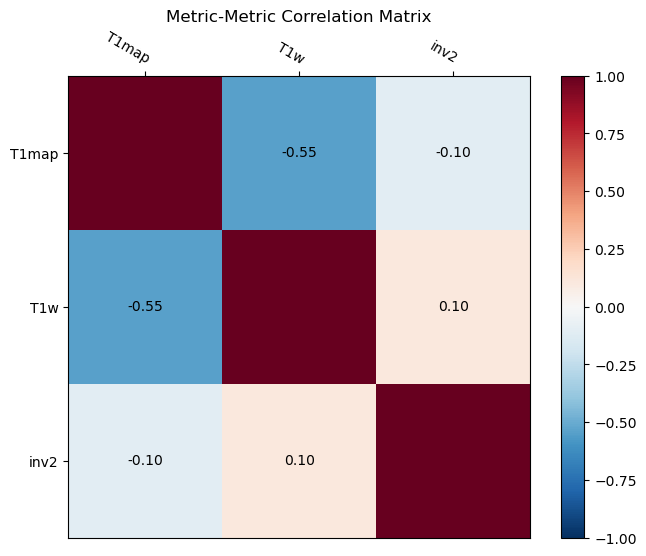

In [7]:
# we can now plot the covariance and correlation of your features should you want to inspect them 
# Calculate covariance (s) and inverse of covariance (pinv_s) of the reference's feature matrix
s, pinv_s = mvc.norm_covar_inv(m_f_mat, mat_mask)

# Show correlation coefficient map 
mvc.correlation_fig(s, reference_fname_list)

# Computing D2

In [8]:
import importlib
mvc = importlib.reload(mvc)
# mysort(glob.glob(os.path.join(feature_source_dir, "*" + suffix_name)))
mvc.feature_list(f"{feature_source_dir}/{IDs[0]}/", ".nii.gz")

Features are :  ['T1map', 'T1w', 'inv2']


(['../local_extras/sample_MRI/001/T1map.nii.gz',
  '../local_extras/sample_MRI/001/T1w.nii.gz',
  '../local_extras/sample_MRI/001/inv2.nii.gz'],
 ['T1map', 'T1w', 'inv2'])

In [9]:
# Compute D2 (with leave-one-out approach; exclude_comp_from_mean_cov= True)
result_dict = mvc.model_comp(feature_in_dir= feature_source_dir, model_dir= None, 
                                 suffix_name_comp= ".nii.gz", 
                                 exclude_comp_from_mean_cov= True, 
                                 mask_f= mask_fname, mask_img= None, verbosity=2, 
                                 mask_threshold=0.99, subject_ids= IDs, 
                                 exclude_subject_ids= None, feat_sub= excluded_features, 
                                 return_raw=False)

# results are stored in a dictionary, can access array of D2 data (of all subjects) like this:
all_D2 = result_dict['all_dist']
all_mask = result_dict['all_mask']
print(all_D2.shape) # Shape will be (number of voxels) x (number of subjects)

# Save matrix containing all D2 data as a numpy array

# np.save('../local_extras/D2_all_subjects.npy', all_D2)


['001', '002', '003', '004']
Features are :  ['T1map', 'T1w', 'inv2']
Feature: T1map
-- Full comp path name identified as: ../local_extras/sample_MRI/001/*T1map*.nii.gz
Feature: T1w
-- Full comp path name identified as: ../local_extras/sample_MRI/001/*T1w*.nii.gz
Feature: inv2
-- Full comp path name identified as: ../local_extras/sample_MRI/001/*inv2*.nii.gz
subject 001 feature matrix creation in 2.89 s
Feature: T1map
-- Full comp path name identified as: ../local_extras/sample_MRI/002/*T1map*.nii.gz
Feature: T1w
-- Full comp path name identified as: ../local_extras/sample_MRI/002/*T1w*.nii.gz
Feature: inv2
-- Full comp path name identified as: ../local_extras/sample_MRI/002/*inv2*.nii.gz
subject 002 feature matrix creation in 2.95 s
Feature: T1map
-- Full comp path name identified as: ../local_extras/sample_MRI/003/*T1map*.nii.gz
Feature: T1w
-- Full comp path name identified as: ../local_extras/sample_MRI/003/*T1w*.nii.gz
Feature: inv2
-- Full comp path name identified as: ../local_e

(0.0, 100.0)

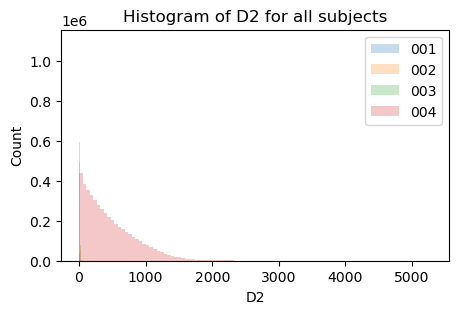

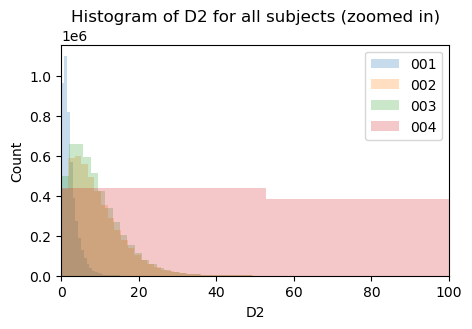

In [10]:
# we can plot all individuals histograms of D2 values, the outlier should have a distribution far outside of the others
common_mask = all_mask.sum(axis=1) == all_mask.shape[1]
plt.figure(figsize=(5,3))
for idx in range(all_D2.shape[1]):
    vec = all_D2[common_mask,idx]
    plt.hist(vec,label=str(IDs[idx]),alpha=0.25,bins=100)
plt.legend()
plt.title('Histogram of D2 for all subjects')
plt.xlabel('D2')
plt.ylabel('Count')

plt.figure(figsize=(5,3))
for idx in range(all_D2.shape[1]):
    vec = all_D2[common_mask,idx]
    plt.hist(vec,label=str(IDs[idx]),alpha=0.25,bins=100)
plt.legend()
plt.title('Histogram of D2 for all subjects (zoomed in)')
plt.xlabel('D2')
plt.ylabel('Count')
plt.xlim(0,100)

[2.2300806821383943, 8.953816219180577, 8.950789238529708, 469.97668860318475]


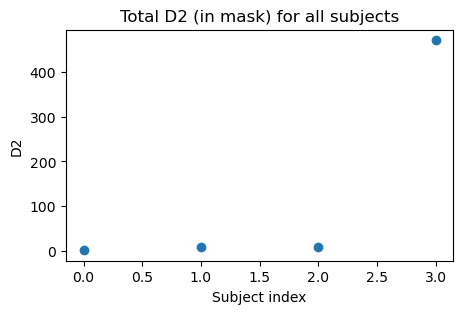

In [11]:
# we can also plot the mean of D2 values within the mask to see if our manipulation worked
# the last subject should be an outlier, with the others exhibiting random variation
common_mask = all_mask.sum(axis=1) == all_mask.shape[1]
mean_d2 = []
for idx in range(all_D2.shape[1]):
    vec = all_D2[common_mask,idx]
    mean_d2.append(vec.mean())
plt.figure(figsize=(5,3))
plt.plot(mean_d2,'o')
plt.title('Total D2 (in mask) for all subjects')
plt.xlabel('Subject index')
plt.ylabel('D2')
print(mean_d2)

## Determining feature importance 
- set `return_raw=True` in `model_comp` to return per-feature values
  - the sum of these values within each voxel is D2

In [12]:
# Extracting distances per feature (raw) using the return_raw=True option of model_comp
result_dict_2 = mvc.model_comp(feature_in_dir= feature_source_dir, model_dir= None, 
                                 suffix_name_comp= ".nii.gz", 
                                 exclude_comp_from_mean_cov= True, 
                                 mask_f= mask_fname, mask_img= None, verbosity=2, 
                                 mask_threshold=0.99, subject_ids= IDs, 
                                 exclude_subject_ids= None, feat_sub= excluded_features, 
                                 return_raw=True)

# results are stored in a dictionary, can access array of D2 data (of all subjects) like this:
all_D2_2 = result_dict_2['all_dist']
all_mask_2 = result_dict_2['all_mask']
raw_D2_2 = result_dict_2['raw_dist']
print(raw_D2_2.shape) # Shape will be (number of voxels) x (number of subjects)


['001', '002', '003', '004']
Features are :  ['T1map', 'T1w', 'inv2']
Feature: T1map
-- Full comp path name identified as: ../local_extras/sample_MRI/001/*T1map*.nii.gz
Feature: T1w
-- Full comp path name identified as: ../local_extras/sample_MRI/001/*T1w*.nii.gz
Feature: inv2
-- Full comp path name identified as: ../local_extras/sample_MRI/001/*inv2*.nii.gz
subject 001 feature matrix creation in 2.87 s
Feature: T1map
-- Full comp path name identified as: ../local_extras/sample_MRI/002/*T1map*.nii.gz
Feature: T1w
-- Full comp path name identified as: ../local_extras/sample_MRI/002/*T1w*.nii.gz
Feature: inv2
-- Full comp path name identified as: ../local_extras/sample_MRI/002/*inv2*.nii.gz
subject 002 feature matrix creation in 2.85 s
Feature: T1map
-- Full comp path name identified as: ../local_extras/sample_MRI/003/*T1map*.nii.gz
Feature: T1w
-- Full comp path name identified as: ../local_extras/sample_MRI/003/*T1w*.nii.gz
Feature: inv2
-- Full comp path name identified as: ../local_e

<BarContainer object of 3 artists>

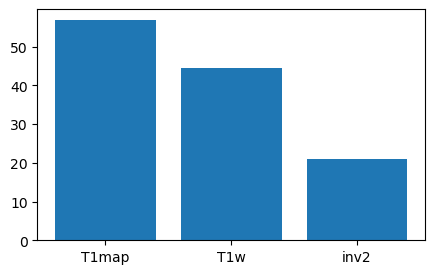

In [13]:
# We can plot the mean raw distances for the mean of our sample
plt.figure(figsize=(5,3))
mean_feature_importance = raw_D2_2.mean(axis=2)
roi_mean = mean_feature_importance.mean(axis=0)
plt.bar(result_dict_2["feature_names"],roi_mean)


# Simplified approach
- same computations as above, but input files can be specified as lists of lists
  - features must be listed in the same order for all individuals

In [14]:
# we can do this equivalently with the simplified approach by passing lists of lists
s1 = glob.glob(os.path.join(feature_source_dir,'001/*'))
s2 = glob.glob(os.path.join(feature_source_dir,'002/*'))
s3 = glob.glob(os.path.join(feature_source_dir,'003/*'))
s4 = glob.glob(os.path.join(feature_source_dir,'004/*'))
all_Ss = [s1,s2,s3,s4]
for S in all_Ss:
    print(S)

res = mvc.model_comp_simplified(all_Ss,mask=mask_fname,verbosity=2)

['../local_extras/sample_MRI/001/T1w.nii.gz', '../local_extras/sample_MRI/001/inv2.nii.gz', '../local_extras/sample_MRI/001/T1map.nii.gz']
['../local_extras/sample_MRI/002/T1w.nii.gz', '../local_extras/sample_MRI/002/inv2.nii.gz', '../local_extras/sample_MRI/002/T1map.nii.gz']
['../local_extras/sample_MRI/003/T1w.nii.gz', '../local_extras/sample_MRI/003/inv2.nii.gz', '../local_extras/sample_MRI/003/T1map.nii.gz']
['../local_extras/sample_MRI/004/T1w.nii.gz', '../local_extras/sample_MRI/004/inv2.nii.gz', '../local_extras/sample_MRI/004/T1map.nii.gz']
No 'model_feature_image_list' was provided
	- Model features will be iteratively computed as the mean of all other subjects (leave one out)
subject None feature matrix creation in 2.91 s
subject None feature matrix creation in 2.9 s
subject None feature matrix creation in 2.88 s
subject None feature matrix creation in 2.85 s
Total time for mahalanobis distance calculation on 4 subjects with 4702024 voxels: 3.16s


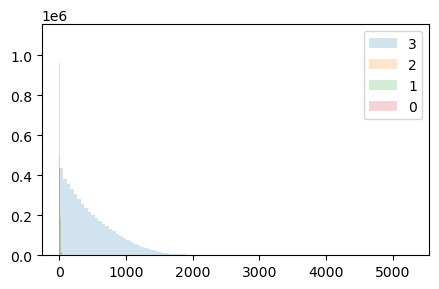

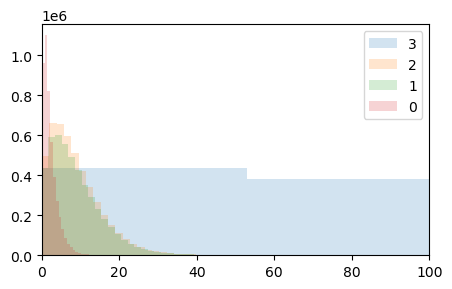

In [15]:
plt.figure(figsize=(5,3))
for idx in range(res['all_dist'].shape[-1])[::-1]: #reverse this, so that the one with more distance is plotted on the backgroun
    plt.hist(res['all_dist'][:,idx],bins=100,alpha=0.2, label=idx)
plt.legend()

plt.figure(figsize=(5,3))
for idx in range(res['all_dist'].shape[-1])[::-1]: #reverse this, so that the one with more distance is plotted on the backgroun
    plt.hist(res['all_dist'][:,idx],bins=100,alpha=0.2, label=idx)

plt.xlim(0,100)
plt.legend()

[2.230080682138394, 8.953816219180583, 8.950789238529707, 469.97668860318447]


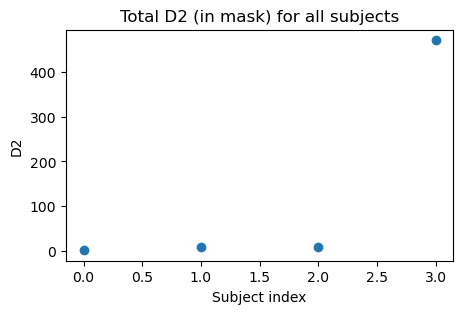

In [16]:
# we can also plot the mean of D2 values within the mask to see if our manipulation worked
# the last subject should be an outlier, with the others exhibiting random variation
common_mask = res['all_mask'].sum(axis=1) == res['all_mask'].shape[1]
mean_d2_simplified = []
for idx in range(res['all_dist'].shape[1]):
    vec =res['all_dist'][common_mask,idx]
    mean_d2_simplified.append(vec.mean())
plt.figure(figsize=(5,3))
plt.plot(mean_d2_simplified,'o')
plt.title('Total D2 (in mask) for all subjects')
plt.xlabel('Subject index')
plt.ylabel('D2')
print(mean_d2_simplified)

In [17]:
# check that the original and simplified approaches return the same values
print(np.allclose(mean_d2,mean_d2_simplified))
print(np.allclose(all_D2,res['all_dist']))

True
True
